This notebook uses corrected $R_{eff}$ estimation data from Tamas Ferenci, and combines it with latest Hungarian data about number of confirmed cases and test positivity downloaded directly from the webpage of Tamas Ferenci (which is downloaded from the Johns Hopkins dashboard).

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [25]:
plt.rcParams["font.size"] = 18

In [11]:
# reading r_eff estimation data from Tamas Ferenci
# institutional and imported cases are excluded in Spring and Summer 2020
# source: e-mailed by the author

ferenci_corrected = pd.read_csv(
    'data/resIntezmenyiEsImportNelkuli.csv',
    sep=";",
    header=None,
    index_col=0
)

ferenci_corrected["date"] = ferenci_corrected[4]\
    .map(lambda i: (datetime(2020,3,3)+timedelta(days=i)).strftime('%Y-%m-%d'))
ferenci_corrected["r_eff"] = ferenci_corrected[1].map(lambda s: float(s.replace(',','.')))
ferenci_corrected["ci_lower"] = ferenci_corrected[2].map(lambda s: float(s.replace(',','.')))
ferenci_corrected["ci_upper"] = ferenci_corrected[3].map(lambda s: float(s.replace(',','.')))
ferenci_corrected["method"] = ferenci_corrected[5]
ferenci_corrected.drop([1,2,3,4,5],axis=1,inplace=True)

ferenci_corrected.head()

,date,r_eff,ci_lower,ci_upper,method
0,,,,,
1,2020-03-11,2.082500,1.190329,3.220095,Cori
2,2020-03-12,1.997289,1.202499,2.990442,Cori
3,2020-03-13,2.138511,1.370184,3.075115,Cori
4,2020-03-14,2.192293,1.468213,3.059217,Cori
5,2020-03-15,2.273213,1.592130,3.073670,Cori


In [3]:
# latest estimations downloaded directly from the webpage of Tamas Ferenci
# has to be downloaded by hand...
# https://research.physcon.uni-obuda.hu/COVID19MagyarEpi/
# Ctrl+C / Ctrl + V whole table from the "Reprodukcios szam becslese" ful > data/ferenci_r_eff.csv

In [12]:
ferenci = pd.read_csv('data/ferenci_r_eff.csv',sep="\t",header=None)
ferenci.columns = ["method","date","junk"]
ferenci["junk"] = ferenci["junk"].map(lambda s: s.replace("("," ").replace(")"," ").replace("-"," "))
ferenci["r_eff"] = ferenci["junk"].map(lambda s: float(s.split(" ")[0]))
ferenci["ci_lower"] = ferenci["junk"].map(lambda s: float(s.split(" ")[2]))
ferenci["ci_upper"] = ferenci["junk"].map(lambda s: float(s.split(" ")[3]))
ferenci["date"] = ferenci["date"].map(lambda d: datetime.strptime(d,"%m/%d/%Y").strftime("%Y-%m-%d"))
ferenci.drop(["junk"],axis=1,inplace=True)

In [13]:
temp = []
for m in ferenci_corrected["method"].unique():
    df1 = ferenci_corrected[ferenci_corrected["method"]==m]
    df2 = ferenci[ferenci["method"]==m]
    temp.extend([df1,df2[df2["date"]>df1["date"].max()]])

In [15]:
data = pd.concat(temp)

In [16]:
# number of cases and test positivity downloaded directly from the webpage of Tamas Ferenci
casenum = pd.read_csv('https://research.physcon.uni-obuda.hu/COVID19MagyarEpi/session/91da14d8fe5f1cf041caf9c52a7cbb2c/download/testpositivityTabDlCSV?w=',sep=";")
casenum["pos"] = casenum["Tesztpozitivitás [%]"].map(lambda s: float(str(s).replace(",", ".")))
casenum["date"] = casenum["Dátum"]

# joining case number and test positivity to the previous results
data["pos"] = data["date"].map(dict(zip(casenum["date"].map(str), casenum["pos"])))
data["casenum"] = data["date"].map(dict(zip(casenum["date"].map(str), casenum["Napi esetszám [fő/nap]"])))

In [17]:
# test view
data

,date,r_eff,ci_lower,ci_upper,method,pos,casenum
1,2020-03-11,2.082500,1.190329,3.220095,Cori,2.479339,3
2,2020-03-12,1.997289,1.202499,2.990442,Cori,2.343750,3
3,2020-03-13,2.138511,1.370184,3.075115,Cori,3.846154,6
4,2020-03-14,2.192293,1.468213,3.059217,Cori,3.153153,7
5,2020-03-15,2.273213,1.592130,3.073670,Cori,2.991453,7
...,...,...,...,...,...,...,...
1034,2021-02-08,1.139379,1.126333,1.149292,Wallinga-Teunis,16.833073,1079
1035,2021-02-09,1.147474,1.138503,1.151401,Wallinga-Teunis,7.603139,1279
1036,2021-02-10,1.152552,1.144045,1.163705,Wallinga-Teunis,9.293272,1862
1037,2021-02-11,1.157579,1.147635,1.168209,Wallinga-Teunis,9.568393,1860


In [18]:
# exporting to csv
data.to_csv('data/reference_r_eff.csv')

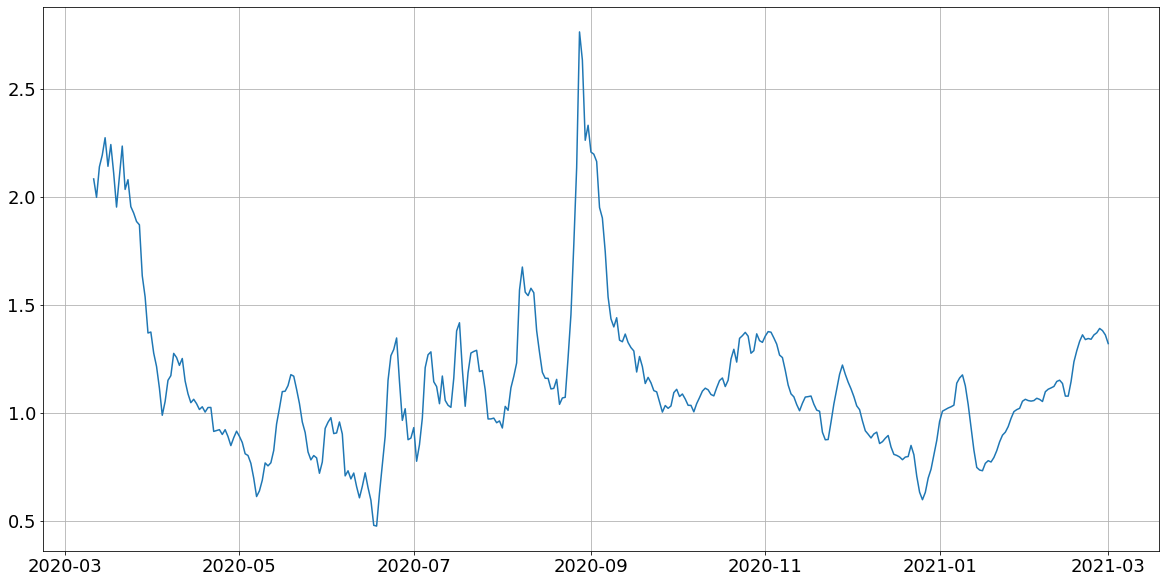

In [26]:
# test figure
plt.figure(figsize=(20,10))
plt.plot(data[data["method"]=="Cori"]["date"].map(lambda d: datetime.strptime(d,"%Y-%m-%d")),data[data["method"]=="Cori"]["r_eff"])
plt.grid()